In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import bz2

import scipy as sp
import scipy.ndimage
import scipy.constants
# CONSTANTS #
kB = sp.constants.value("Boltzmann constant in eV/K") # unit: eV/K
qe = sp.constants.value("elementary charge") # unit: C
me = sp.constants.value("electron mass")/qe*1e-18 #unit: eV*s^2/nm^2
hP = sp.constants.value("Planck constant in eV s") #unit: eV*s
hbar = hP/(2*sp.pi) #unit: eV*s
eps0 = sp.constants.value("electric constant")*qe*1e-9 #unit: C^2/(eV*nm)

## Load VASP potential
Assuming it has been compressed with bz2.

In [2]:
def load_vasp_bz2(filepath):
    
    with bz2.BZ2File(filepath) as f:
        head = [next(f) for _ in range(8)]
        box_x = float(head[2].split()[0])
        box_y = float(head[3].split()[1])
        box_z = float(head[4].split()[2])
        num_atoms = int(head[6].strip())

        atoms = np.zeros((num_atoms, 3))
        for i in range(num_atoms):
            line = next(f).split()
            for j, st in enumerate(line):
                atoms[i, j] = float(st)

        next(f)
        nums_line = next(f).split()
        num_x = int(nums_line[0])
        num_y = int(nums_line[1])
        num_z = int(nums_line[2])

        values = np.zeros(num_x*num_y*num_z)
        index = 0;
        for line in f:
            if line.split()[0] == "augmentation":
                break
            parts = line.split()
            for part in parts:
                values[index] = float(part)
                index += 1

    box = np.array([box_x, box_y, box_z])
    num = np.array([num_x, num_y, num_z])
    
    values = np.reshape(values, (num[0], num[1], num[2]), order='F')
    
    return box, num, values, atoms

In [3]:
pot_file = "D:\\Work\\dft_work_function\\new_data\\03_Single\\03_0.40\\LOCPOT_FULL.bz2"

box_raw, num_raw, pot_raw, atoms = load_vasp_bz2(pot_file)

In [4]:
outcar_file = "D:\\Work\\dft_work_function\\new_data\\03_Single\\03_0.40\\OUTCAR"

e_fermi = 0.0
with open(outcar_file) as f:
    for line in f:
        if "E-fermi" in line:
            e_fermi = float(line.split()[2])
            break
            
print("Fermi:" + str(e_fermi))

Fermi:-2.5048


### Plot and transform the potential landscape

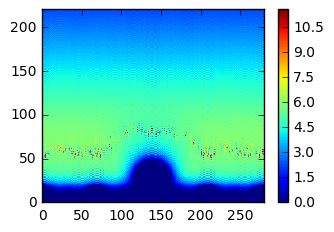

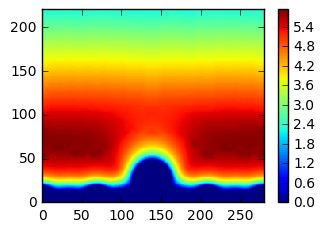

In [5]:
# Zero potential relative to fermi level 
e_zero = -3.0

def transform(roll_x, roll_y, z_start, z_end):
    pot = np.roll(pot_raw, roll_x, axis=0)
    pot = np.roll(pot, roll_y, axis=1)
    
    pot = pot[:,:,z_start:z_end]
    num = np.copy(num_raw); num[2] = z_end-z_start
    box = np.copy(box_raw); box[2] = box_raw[2]*num[2]/num_raw[2]
    return pot, num, box

pot, num, box = transform(roll_x=140, roll_y=140, z_start=200, z_end=420)

# Gaussian smoothing:
pot_gf = sp.ndimage.filters.gaussian_filter(pot, 2.5)
# clamp:
pot_gf -= e_fermi + e_zero
pot_gf[pot_gf < 0.0] = 0.0

# Plot original data:
f = plt.figure(figsize=(1.2*box[0]/6,box[2]/6))
plot_val = np.copy(pot[num[0]//2, :, :])
plot_val -= e_fermi + e_zero
plot_val[plot_val < 0.0] = 0.0
cm = plt.pcolormesh(np.rot90(plot_val, 3))
f.gca().axis('tight')
f.colorbar(cm)
plt.show()

# Plot with gaussian smoothing:
f = plt.figure(figsize=(1.2*box[0]/6,box[2]/6))
cm = plt.pcolormesh(np.rot90(pot_gf[num[0]//2, :, :], 3))
f.gca().axis('tight')
f.colorbar(cm)
plt.show()

# Extend vacuum to zero potential

Final boundary pot: 0.000000


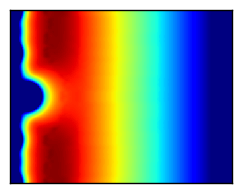

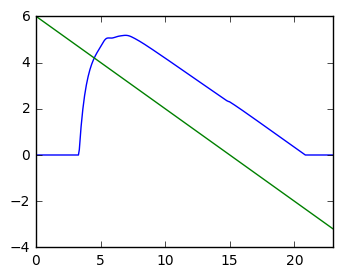

In [6]:
# Extent vacuum by (angstroms)

e_field = 0.40 # V/ang
z_extra = 8.0

dx = box/num

z_num_extra = int(z_extra/dx[2])

pot_ext = np.empty((num[0], num[1], num[2]+z_num_extra))

pot_ext[:num[0], :num[1], :num[2]] = pot_gf

step = -e_field*dx[2]

for i in range(z_num_extra):
    pot_ext[:, :, num[2]+i] = 0.9*pot_ext[:, :, num[2]+i-1]+0.1*np.mean(pot_ext[:, :, num[2]+i-1])+ step

pot_ext[pot_ext<0.0] = 0.0

box_ext = box + np.array([0.0, 0.0, z_extra])
num_ext = num + np.array([0, 0, z_num_extra])

print("Final boundary pot: %f"%np.mean(pot_ext[:, :, -1]))

f = plt.figure(figsize=(box_ext[2]/8,box_ext[0]/8))
cm = plt.pcolormesh(pot_ext[num[0]//2, :, :])
f.gca().axis('tight')
plt.xticks([])
plt.yticks([])
plt.show()

# Plot a 1d with real field to verify slope
f = plt.figure(figsize=(box_ext[2]/6,box_ext[0]/6))
pdata = pot_ext[num[0]//2, num[1]//2, :]
zdata = np.linspace(0, box_ext[2], len(pdata)) 
plt.plot(zdata, pdata)
plt.xlim([0, zdata[-1]])
field_data = -e_field*zdata+6
plt.plot(zdata, field_data)
plt.show()

# Save the barrier to npz file

In [7]:
# Downsample the potential to save some space
dws = 2
pot_dws = pot_ext[::dws, ::dws, ::dws]

In [8]:
barrier_data_file = "./example/vasp_cu_adatom_e0.4.npz"
# Box needs to be converted to nm
np.savez(barrier_data_file, pot=pot_dws, box=box_ext/10)